#Proyecto: Redes Neuronales en Clasificación

## Introducción
¿Qué son las redes neuronales?
Una red neuronal es un método de la inteligencia artificial que enseña a las computadoras a procesar datos de una manera que está inspirada en la forma en que lo hace el cerebro humano.

En este proyecto exploraremos la aplicación de las redes neuronales para identificar la droga que debe suministrase a los pacientes de un conjunto de datos que contiene el registro de prescripciones de diferentes drogas recomendadas a pacientes con diferentes características. 

Tareas a realizar:
- Divide los datos en tres subconjuntos: entrenamiento, validación y prueba.
- Ajusta redes redes neuronales con diferente arquitectura (5 por lo menos). 
- Elige la mejor red neuronal evaluando el error sobre el conjunto de validación.
- Estima el poder predictivo del modelo al generalizarlo evaluando la exactitud su exactitud sobre el conjunto de prueba. 

In [ ]:
#Librerias a utilizar
from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


Estas son las funciones auxiliares de trazado que se utilizan más adelante en el cuaderno.


In [ ]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred_temp = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_temp,axis=1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('accuracy', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

Cargamos el archivo csv de drogas

In [ ]:
df = pd.read_csv('drug200.csv')
df.sample(n=5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
128,47,M,LOW,NORMAL,33.54,DrugY
25,28,F,HIGH,NORMAL,18.81,DrugY
161,57,F,HIGH,NORMAL,9.95,drugB
193,72,M,LOW,HIGH,6.77,drugC
62,67,M,LOW,NORMAL,20.69,DrugY


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
df.Drug.value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [ ]:
df.Sex.value_counts()

M    104
F     96
Name: Sex, dtype: int64

In [ ]:
df.BP.value_counts()

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

In [ ]:
df.Cholesterol.value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

In [ ]:
df.describe()

,Age,Na_to_K
count,200.00,200.00
mean,44.31,16.08
std,16.54,7.22
min,15.00,6.27
25%,31.00,10.45
50%,45.00,13.94
75%,58.00,19.38
max,74.00,38.25


In [ ]:
skewAge = df.Age.skew(axis = 0, skipna = True)
print('Age skewness: ', skewAge)

Age skewness:  0.03030835703000607


In [ ]:
skewNatoK = df.Na_to_K.skew(axis = 0, skipna = True)
print('Na to K skewness: ', skewNatoK)

Na to K skewness:  1.039341186028881


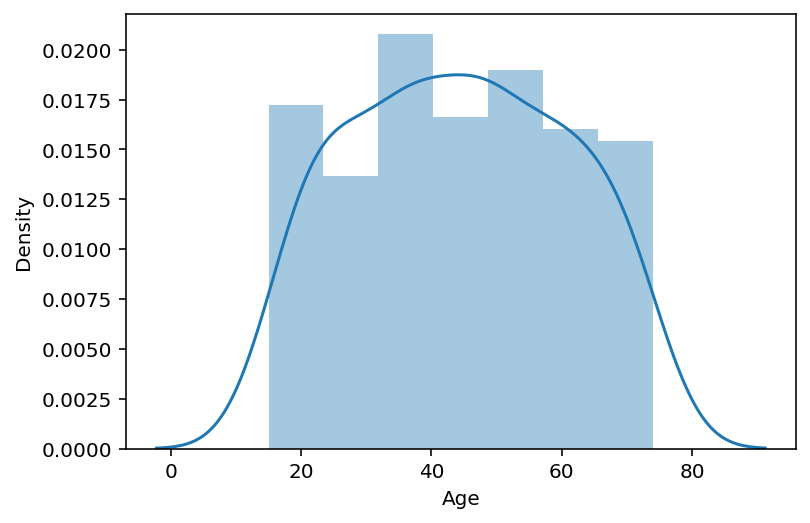

In [ ]:
sns.distplot(df['Age']);

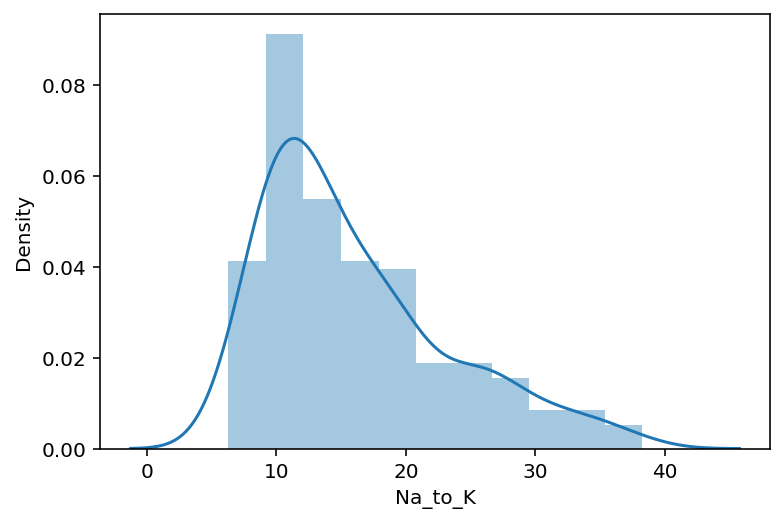

In [ ]:
sns.distplot(df['Na_to_K']);

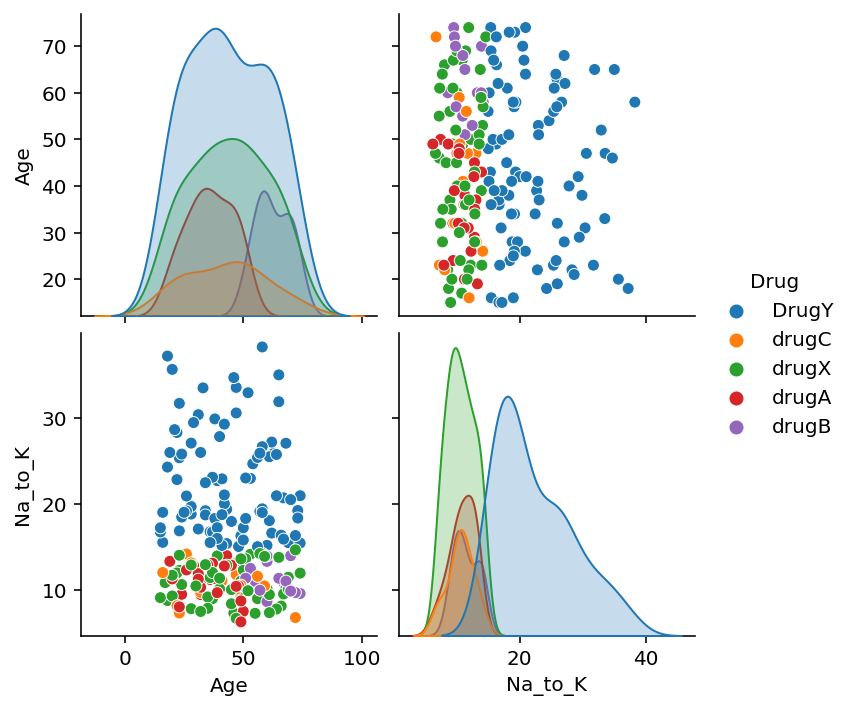

In [ ]:
sns.pairplot(df, hue='Drug')

## Implementación

In [ ]:
#Dividimos las caracteristicas de la variable resultante
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Categorizamos las columnas de sex, BP, Cholesterol y Drug

# columna sex
le = LabelEncoder()
X[:, 1] = le.fit_transform(X[:, 1])


# Columnas BP y Cholestero
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2, 3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Columna Drug
encoder = OneHotEncoder()
encoded_Y = encoder.fit(y.reshape(-1,1))
y = encoded_Y.transform(y.reshape(-1,1)).toarray()

In [ ]:
#Creamos nuestros subconjuntos de datos: entrenamiento, validación y prueba.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

print("Train dataset")
print(X_train.shape), print(y_train.shape)
print(" ")
print("Validation dataset")
print(X_valid.shape), print(y_valid.shape)
print(" ")
print("Test dataset")
print(X_test.shape), print(y_test.shape)

Train dataset
(160, 8)
(160, 5)
 
Validation dataset
(20, 8)
(20, 5)
 
Test dataset
(20, 8)
(20, 5)


(None, None)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

<Figure size 576x432 with 0 Axes>

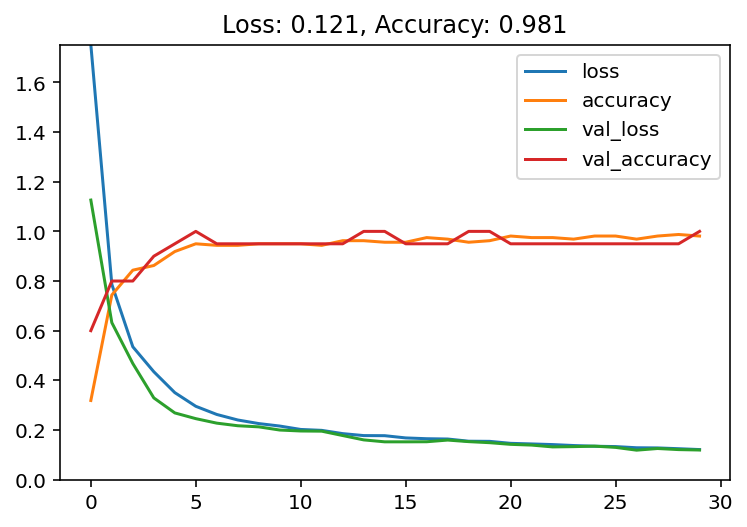

In [ ]:
#Creamos nuestro primer modelo utilizando softmax, categorical conssentropy e imprimimos la grafica de perdida y presición
def fun_model_1():
  model_1 = Sequential()
  model_1.add(Dense(5, activation='softmax'))
  model_1.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
  return model_1

model_1 = fun_model_1()
history_1 = model_1.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)
plot_loss_accuracy(history_1)

In [ ]:
#Evaluamos el modelo con el conjunto de datos de prueba
model_1.evaluate(X_test, y_test, verbose=0)

[0.09779547154903412, 1.0]

1/1 [==============================] - 0s 70ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



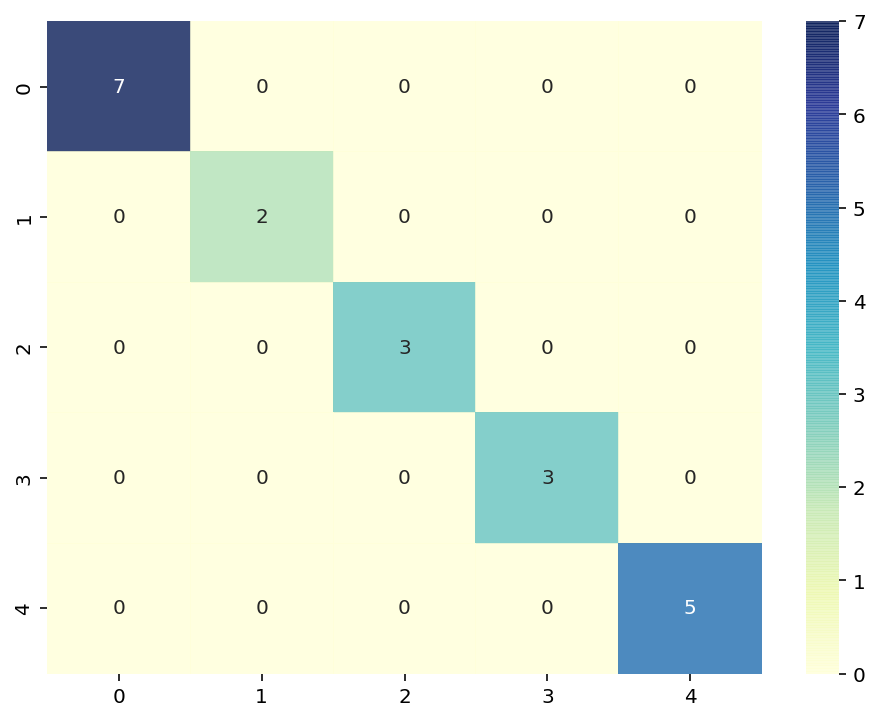

In [ ]:
predict_x = model_1.predict(X_test) 
y_pred_class = np.argmax(predict_x,axis=1)

y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model_1, X_test, y_test_class)

Epoch 1/100
5/5 [==============================] - 1s 52ms/step - loss: 1.1506 - accuracy: 0.5437 - val_loss: 0.6216 - val_accuracy: 0.7000
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5437 - accuracy: 0.8000 - val_loss: 0.3840 - val_accuracy: 0.8500
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.2420 - accuracy: 0.9062 - val_loss: 0.1201 - val_accuracy: 0.9500
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.1735 - accuracy: 0.9062 - val_loss: 0.1105 - val_accuracy: 0.9500
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.2619 - accuracy: 0.9375 - val_loss: 0.1428 - val_accuracy: 0.9000
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.4870 - accuracy: 0.9312 - val_loss: 0.2956 - val_accuracy: 0.9500
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.4023 - accuracy: 0.9062 - val_loss: 0.9327 - val_accuracy: 0.8500
Epoch 8/100
5/5 [========

<Figure size 576x432 with 0 Axes>

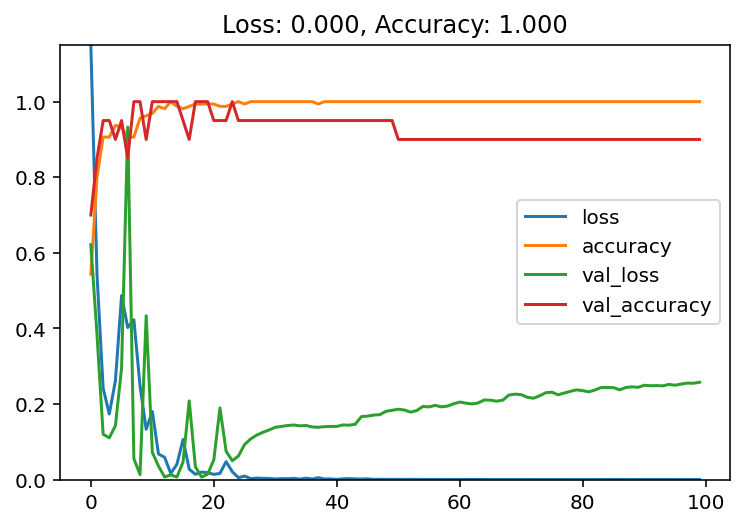

In [ ]:
#Creamos nuestro segundo modelo con 2 capas adicionales utilizando relu, softmax, categorical conssentropy e imprimimos la grafica de perdida y presición
def fun_model_2():
  model_2 = Sequential()
  model_2.add(Dense(16, activation='relu'))
  model_2.add(Dense(16, activation='relu'))
  model_2.add(Dense(5, activation='softmax'))
  model_2.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
  return model_2

model_2 = fun_model_2()
history_2 = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
plot_loss_accuracy(history_2)

In [ ]:
#Evaluamos el modelo con el conjunto de datos de prueba
model_2.evaluate(X_test, y_test, verbose=0)

[0.004583906847983599, 1.0]

1/1 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



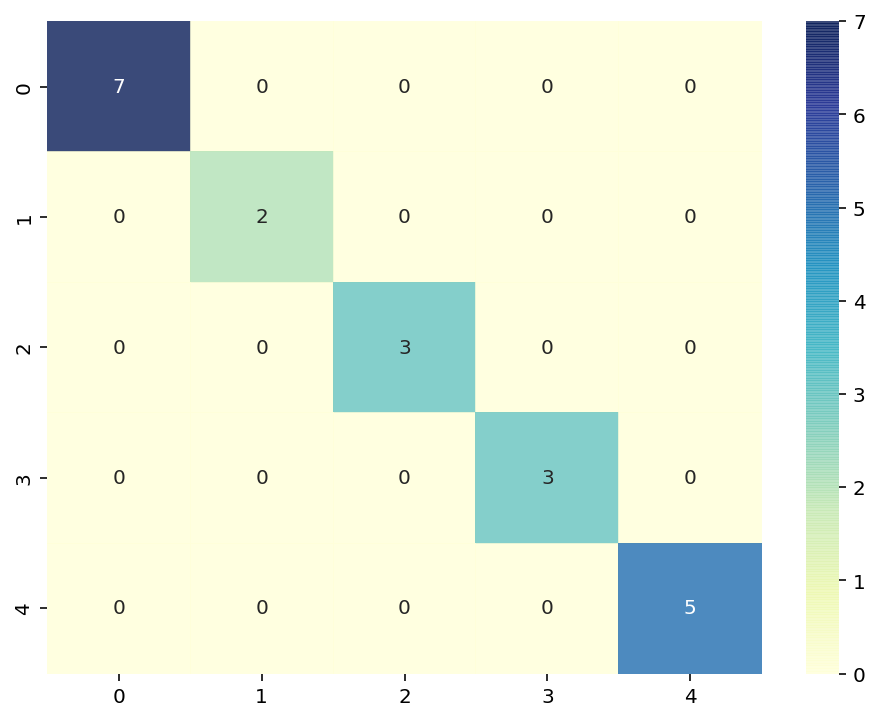

In [ ]:
predict_x = model_2.predict(X_test) 
y_pred_class = np.argmax(predict_x,axis=1)

y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model_2, X_test, y_test_class)

<Figure size 576x432 with 0 Axes>

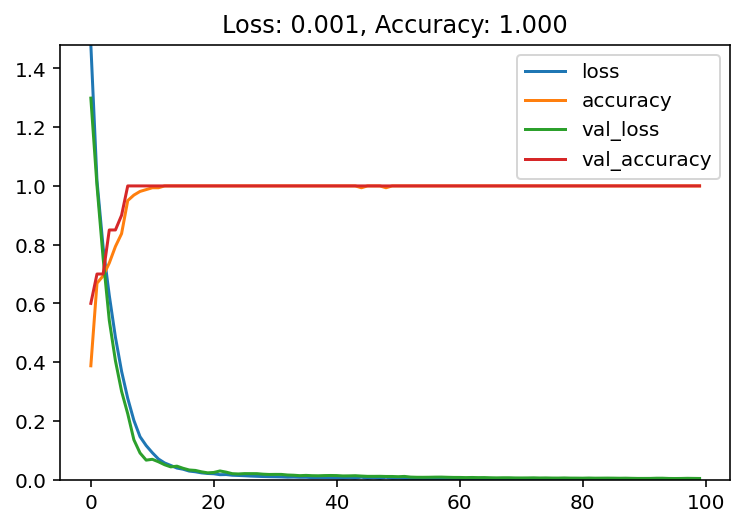

In [ ]:
#Creamos nuestro tercer modelo con 3 capas utilizando relu, esta vez con mas neuronas y haciendo mas pequeño lr, softmax, categorical conssentropy e imprimimos la grafica de perdida y presición
def fun_model_3():
  model_3 = Sequential()
  model_3.add(Dense(32, activation='relu'))
  model_3.add(Dense(16, activation='relu'))
  model_3.add(Dense(5, activation='softmax'))
  model_3.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model_3

model_3 = fun_model_3()
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_3 = model_3.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), verbose=0)
plot_loss_accuracy(history_3)

In [ ]:
# Evaluamos el modelo con el conjunto de datos de prueba
model_3.evaluate(X_test, y_test, verbose=0)

[0.03086348995566368, 1.0]

1/1 [==============================] - 0s 51ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



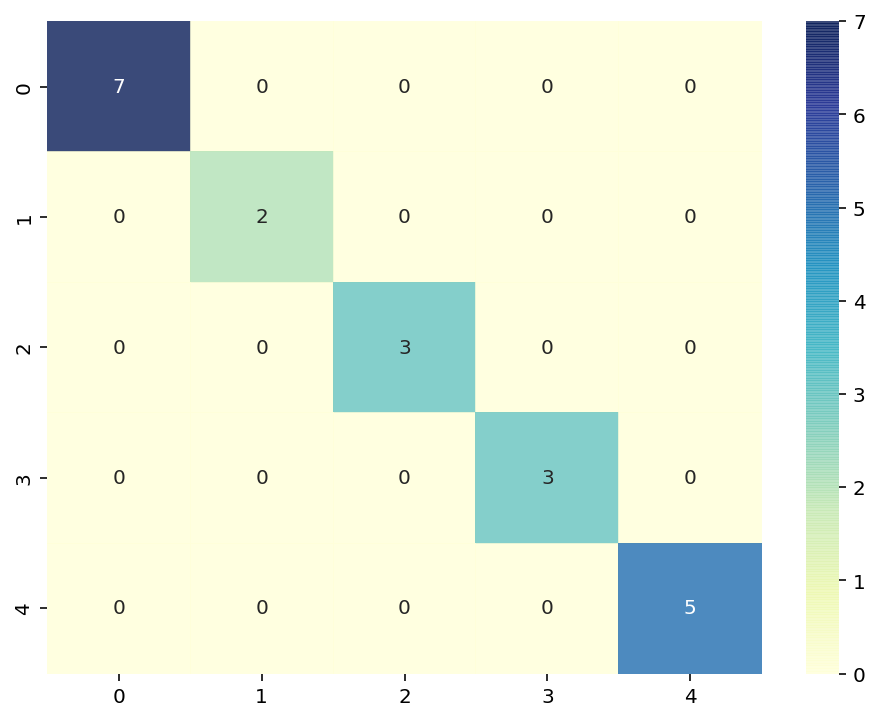

In [ ]:
predict_x = model_3.predict(X_test) 
y_pred_class = np.argmax(predict_x,axis=1)

y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model_3, X_test, y_test_class)

Epoch 54: early stopping


<Figure size 576x432 with 0 Axes>

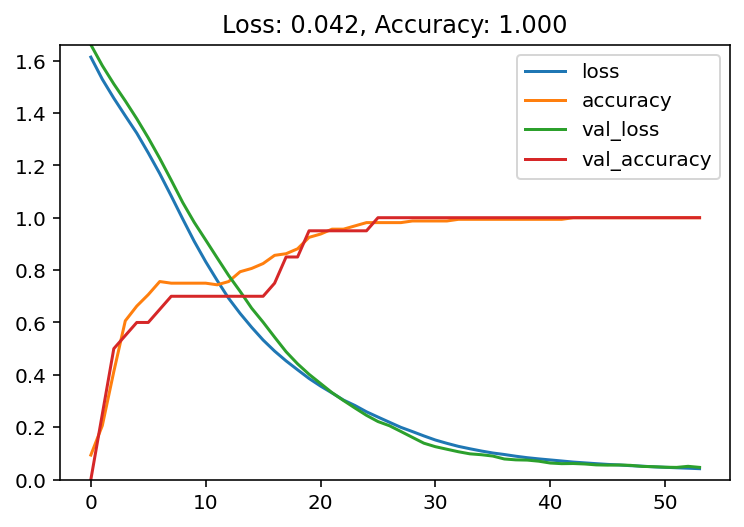

In [ ]:
#Creamos nuestro cuarto modelo con 4 capas haciendolo mas profundo, utilizando relu, esta vez con mas neuronas y haciendo mas pequeño lr, softmax, categorical conssentropy e imprimimos la grafica de perdida y presición
def fun_model_4():
  model_4 = Sequential()
  model_4.add(Dense(64, activation='relu'))
  model_4.add(Dense(32, activation='relu'))
  model_4.add(Dense(16, activation='relu'))
  model_4.add(Dense(5, activation='softmax'))
  model_4.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model_4

model_4 = fun_model_4()

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_4 = model_4.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), verbose=0, callbacks=[early_stop])
plot_loss_accuracy(history_4)

In [ ]:
# Evaluamos el modelo con el conjunto de datos de prueba
model_4.evaluate(X_test, y_test, verbose=0)

[0.03396574780344963, 1.0]

1/1 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



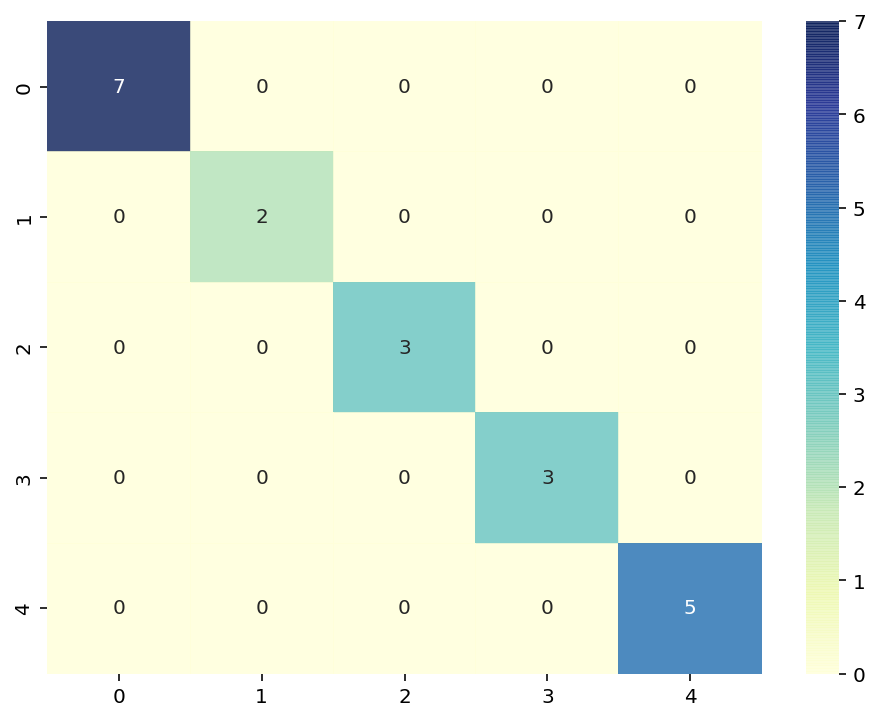

In [ ]:
predict_x = model_4.predict(X_test) 
y_pred_class = np.argmax(predict_x,axis=1)

y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model_4, X_test, y_test_class)

## Sparse Categorical Crossentropy

Basado en investigación, ajustamos un modelo a los datos con una formula de perdida diferente "Sparse Categorical Conssentropy" por lo que se manejaron los datos de forma diferente para que los shapes cuadraran en el modelo

In [ ]:
# Cambiamos las variables categoricas por numericas para hacer mas sencillo el analisis del modelo
df2 = df.copy()

df2.Sex.replace({'M', 'F'},{1, 0}, inplace=True)
df2.BP.replace({'HIGH', 'LOW', 'NORMAL'},{0, 2, 1}, inplace=True)
df2.Cholesterol.replace({'HIGH', 'NORMAL'},{0, 1}, inplace=True)
df2.Drug.replace({'DrugY', 'drugA', 'drugB', 'drugC', 'drugX'},{0, 1, 2, 3, 4}, inplace=True)

df2.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.36,0
1,47,1,1,1,13.09,3
2,47,1,1,1,10.11,3
3,28,0,0,1,7.80,2
4,61,0,1,1,18.04,0


In [ ]:
#Creamos los subconjuntos de entrenamiento, validación y prueba.
X = df2.drop(["Drug"], axis=1)
y = df2["Drug"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

print("Train dataset")
print(X_train.shape), print(y_train.shape)
print(" ")
print("Validation dataset")
print(X_valid.shape), print(y_valid.shape)
print(" ")
print("Test dataset")
print(X_test.shape), print(y_test.shape)

Train dataset
(160, 5)
(160,)
 
Validation dataset
(20, 5)
(20,)
 
Test dataset
(20, 5)
(20,)


(None, None)

Epoch 1/1000
5/5 [==============================] - 1s 50ms/step - loss: 9.2385 - accuracy: 0.0688 - val_loss: 7.3041 - val_accuracy: 0.2000
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.2848 - accuracy: 0.1063 - val_loss: 5.7177 - val_accuracy: 0.3000
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 4.3288 - accuracy: 0.3438 - val_loss: 4.9241 - val_accuracy: 0.3500
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 3.4164 - accuracy: 0.4750 - val_loss: 3.9362 - val_accuracy: 0.3500
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.6234 - accuracy: 0.4812 - val_loss: 2.8775 - val_accuracy: 0.4000
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.9662 - accuracy: 0.4437 - val_loss: 1.9032 - val_accuracy: 0.4000
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.3866 - accuracy: 0.4500 - val_loss: 1.3135 - val_accuracy: 0.5500
Epoch 8/1000
5/5 [

<Figure size 576x432 with 0 Axes>

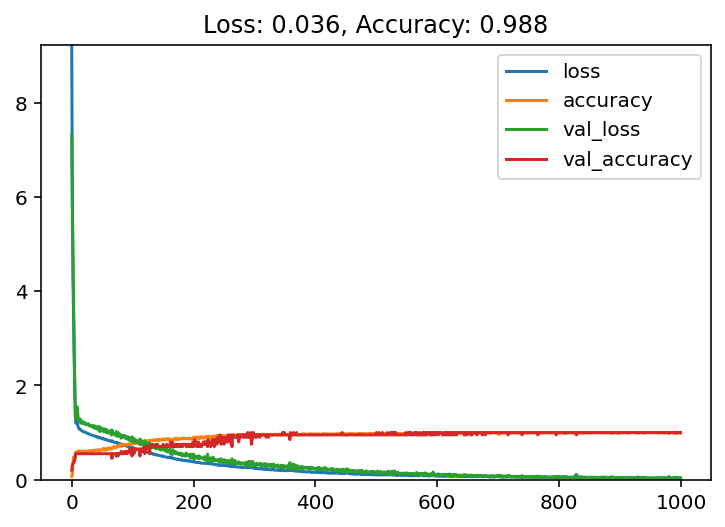

In [ ]:
#Creamos nuestro quinto modelo con 3 capas, utilizando relu, softmax, sparse categorical conssentropy e imprimimos la grafica de perdida y presición
def fun_model_5():
  model_5 = Sequential()
  model_5.add(Dense(60, activation='relu'))
  model_5.add(Dense(30, activation='relu'))
  model_5.add(Dense(5, activation='softmax'))
  model_5.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_5

model_5 = fun_model_5();
history_5 = model_5.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid))
plot_loss_accuracy(history_5)

In [ ]:
# Evaluamos el modelo con los datos del conjunto de pruebas
model_5.evaluate(X_test, y_test, verbose=0)

[0.0591568760573864, 1.0]

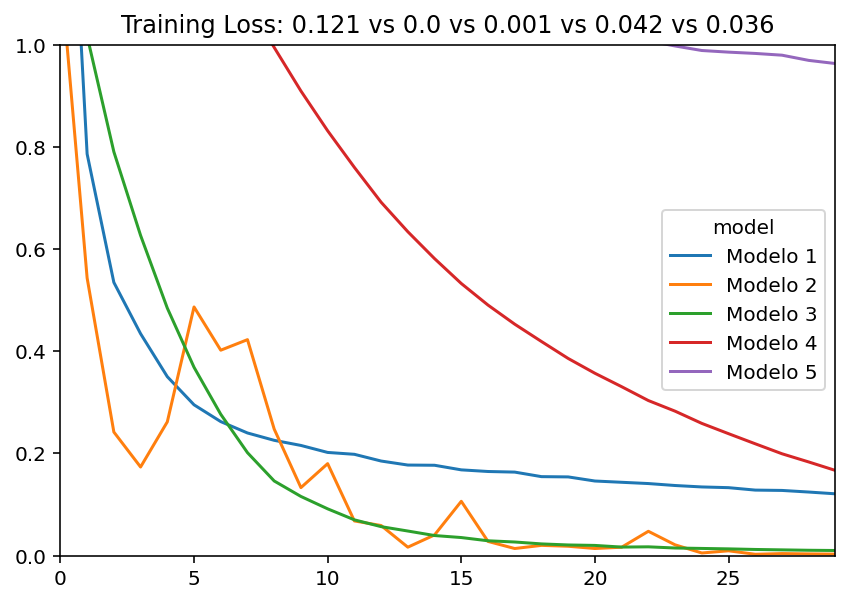

In [ ]:
# Hacemos una comparacion entre los 5 modelos
plot_compare_histories([history_1,history_2,history_3,history_4,history_5], ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5'], plot_accuracy=False)

In [ ]:
# Evaluamos el porcentaje de presicion de los modelos con validacion cruzada
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

model_1 = KerasClassifier(build_fn=fun_model_1, epochs=100, verbose=0)
model_1_scores = cross_val_score(model_1, X, df['Drug'].values, cv=cv)
print(model_1_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*model_1_scores.mean(), 100*model_1_scores.std()*2))

model_2 = KerasClassifier(build_fn=fun_model_2, epochs=100, verbose=0)
model_2_scores = cross_val_score(model_2, X, df['Drug'].values, cv=cv)
print(model_2_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*model_2_scores.mean(), 100*model_2_scores.std()*2))

model_3 = KerasClassifier(build_fn=fun_model_3, epochs=100, verbose=0)
model_3_scores = cross_val_score(model_3, X, df['Drug'].values, cv=cv)
print(model_3_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*model_3_scores.mean(), 100*model_3_scores.std()*2))

model_4 = KerasClassifier(build_fn=fun_model_4, epochs=500, verbose=0)
model_4_scores = cross_val_score(model_4, X, df['Drug'].values, cv=cv)
print(model_4_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*model_4_scores.mean(), 100*model_4_scores.std()*2))

model_5 = KerasClassifier(build_fn=fun_model_5, epochs=1000, verbose=0)
model_5_scores = cross_val_score(model_5, X, df['Drug'].values, cv=cv)
print(model_5_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*model_5_scores.mean(), 100*model_5_scores.std()*2))

[0.875      0.77499998 0.97500002 0.875      0.92500001]
Accuracy: 88.50% (+/- 13.27%)
[0.72500002 0.82499999 0.82499999 0.77499998 0.625     ]
Accuracy: 75.50% (+/- 14.97%)
[0.85000002 0.92500001 0.82499999 0.875      0.92500001]
Accuracy: 88.00% (+/- 8.00%)
[0.92500001 0.97500002 0.97500002 0.94999999 0.89999998]
Accuracy: 94.50% (+/- 5.83%)
[0.85000002 0.97500002 1.         0.92500001 0.97500002]
Accuracy: 94.50% (+/- 10.68%)


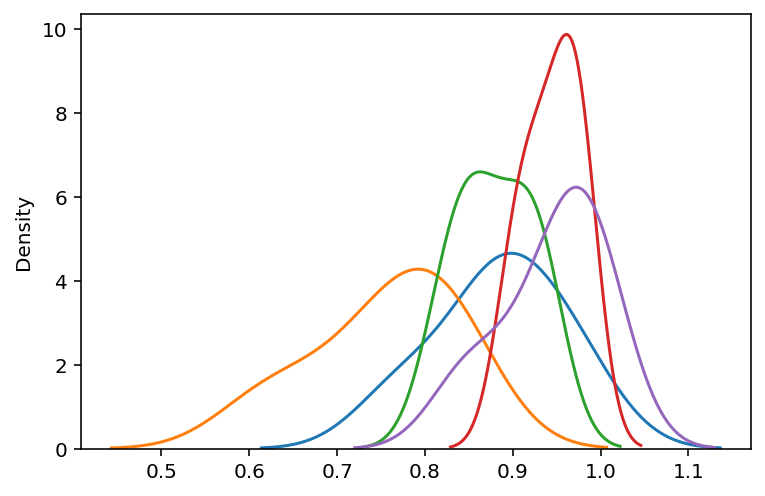

In [ ]:
sns.distplot(model_1_scores, hist=False, label='modelo 1')
sns.distplot(model_2_scores, hist=False, label='modelo 2')
sns.distplot(model_3_scores, hist=False, label='modelo 3')
sns.distplot(model_4_scores, hist=False, label='modelo 4')
sns.distplot(model_5_scores, hist=False, label='modelo 5')

## Conclusión

Como podemos observar en el porcentaje de precision al momento de evaluar los modelos, el mas alto es el modelo 4 creado con 4 capas, de 64, 32, 16 y 5, utilizando relu y softmax y con la funcion de perdida categorical crossentropy. De igual forma comparte el puesto mas alto con el modelo 5 que utiliza una funcion diferente de perdida.